# <center> Portfolio Project - Credit Card Delinquency Prediciton by Atul Pai <center>

## 1. Import required libraries

In [293]:
import pandas as pd
import numpy as np
import re

# visualiation libraries
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline as Pipe # distinguish from imblearn pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV

# feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_selection import RFE

# model interpretablity
import eli5
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer
import shap
import lime

#import shap

# algos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

# preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin #inheritance class for custom transformers

# metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import make_scorer,recall_score

# saving the pipeline
import joblib

import warnings
warnings.filterwarnings('ignore')

# importing libraries for Deep Learning

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, Activation
from sklearn.metrics import plot_roc_curve

## 2. Load Dataset

In [3]:
data = pd.read_csv('C:/Users/atulp/Desktop/Portfolio Project/cs-training.csv') ## download the data into dataframe

In [4]:
data.info() ## 10 explanatory variables, binary label SeriousDlqin2yrs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

-Description of different fields of the data

- Aim : Predict Serious Delinquency defined by whether an account holder doesn't pay after 90 days of past due date, based on <br>  above factors            

## 3. Exploratory Data Analysis

### 3.1 Train Test Split

In [299]:
y = data['SeriousDlqin2yrs']
X = data.drop(columns=['SeriousDlqin2yrs'])

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify =y)
## initial test train split 

0.0

### 3.2 EDA

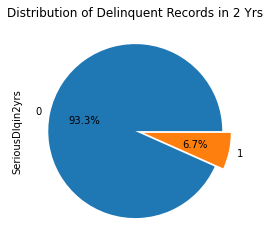

In [360]:
y.value_counts().plot.pie(explode=[0,0.1],autopct ='%1.1f%%') ## Highly impbalanced data
plt.title('Distribution of Delinquent Records in 2 Yrs');


## 6.7% of the records are labeled as delinquent


#### Some univariate analysis

In [8]:
def hist_box_response(column): ## helper function to build plots, first is the frequency dist, second boxplot and third 
                               ## delinquency percentage by deciles
        
    fig,ax=plt.subplots(3,1,figsize=(8,8), tight_layout = True)
    sns.distplot(X_train[X_train[column].notnull()][column],ax=ax[0]) ## plot distribution with density
    sns.boxplot(y=X_train[X_train[column].notnull()][column],ax=ax[1]) ## plot boxplot to see the distribution for outliers
    
    d_labels =['d1','d2','d3','d4','d5','d6','d7','d8','d9','d10'] ## break the explanatory variables into deciles
    plotter = pd.DataFrame()
    plotter[column] = pd.qcut(
        X_train[X_train[column].notnull()][column],
        10,
        labels=d_labels,
        )
    y_plot = y_train.copy()
    y_plot = y_train[X_train[column].notnull()]
    y_plot.reset_index(drop=True, inplace=True)
    plotter.reset_index(drop=True, inplace=True)
    plotter = pd.concat([plotter,y_plot],axis =1)
    plotter.groupby(column)['SeriousDlqin2yrs'].mean().plot(kind='bar') ## see the distribution of delinquency rate against 
    ax[2].set(ylabel ="Delinquency Rate");                              ## the deciles of explanatory variable
    
def count_box_response(column): ## helper function to build plots, first is the frequency dist, second boxplot and third 
                               ## delinquency percentage by deciles
        
    fig,ax=plt.subplots(3,1,figsize=(8,8), tight_layout = True)    ## plot distribution with density
    sns.distplot(X_train[X_train[column].notnull()][column],ax=ax[0])
    sns.boxplot(y=X_train[X_train[column].notnull()][column],ax=ax[1])
    
   
    plotter = pd.DataFrame()
    plotter[column] =  X_train[X_train[column].notnull()][column]      
        
    y_plot = y_train.copy()
    y_plot = y_train[X_train[column].notnull()]
    y_plot.reset_index(drop=True, inplace=True)
    plotter.reset_index(drop=True, inplace=True)
    plotter = pd.concat([plotter,y_plot],axis =1)
    plotter.groupby(column)['SeriousDlqin2yrs'].mean().plot(kind='bar') ## see the distribution of delinquency rate against
    ax[2].set(ylabel ="Delinquency Rate");                              ## each discrete point of the explanatory variable

#### 1.RevolvingUtilizationOfUnsecuredLines

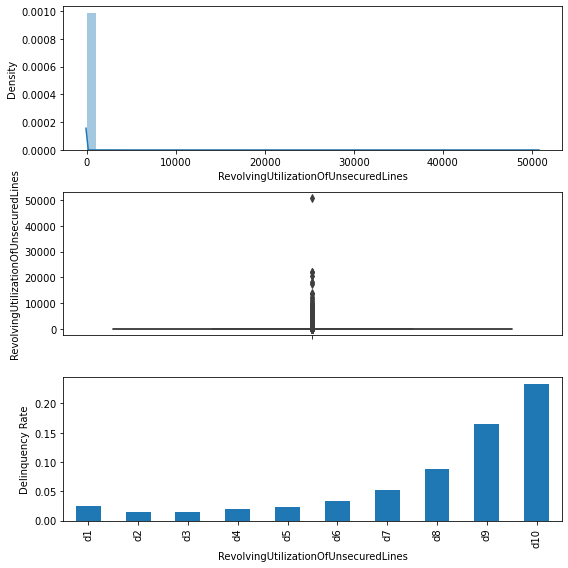

In [9]:
hist_box_response('RevolvingUtilizationOfUnsecuredLines')

- Observations : Outliers present, seems like after the 75th percentile the Delinquency rate shoots up, looks like an important feature by itself. Removing outliers will lead to loss of info, so keep the column as is.

#### 2. age

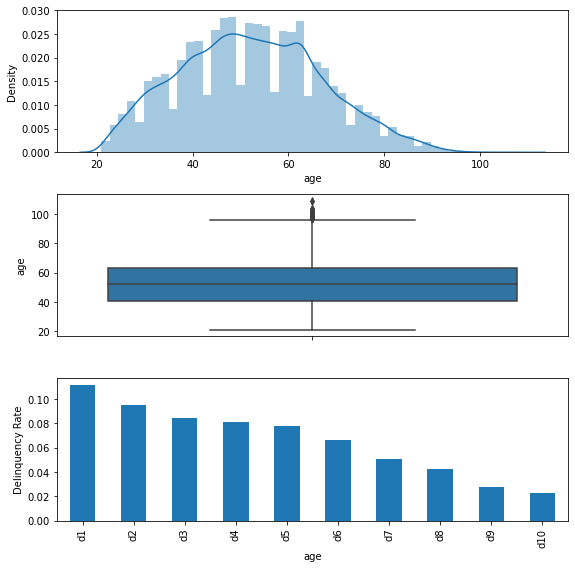

In [10]:
hist_box_response('age')

- Observations : Outliers present, seems like after the 75th percentile the Delinquency rate goes down, looks like an important feature by itself. Removing outliers will lead to loss of info, so keep the column as is.

#### 3. NumberOfTime30-59DaysPastDueNotWorse

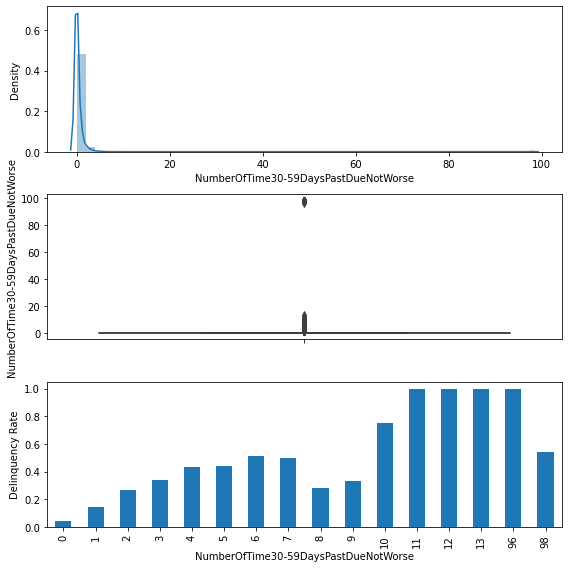

In [11]:
count_box_response('NumberOfTime30-59DaysPastDueNotWorse')

- Observations : As NumberOfTime30-59DaysPastDueNotWorse increases, delinquency rate goes up, looks like an important feature by itself, outliers behave differently, therefore it's best to keep them. 96 and 98 seem to be way away from the other points. 

#### 4. NumberOfTime60-89DaysPastDueNotWorse

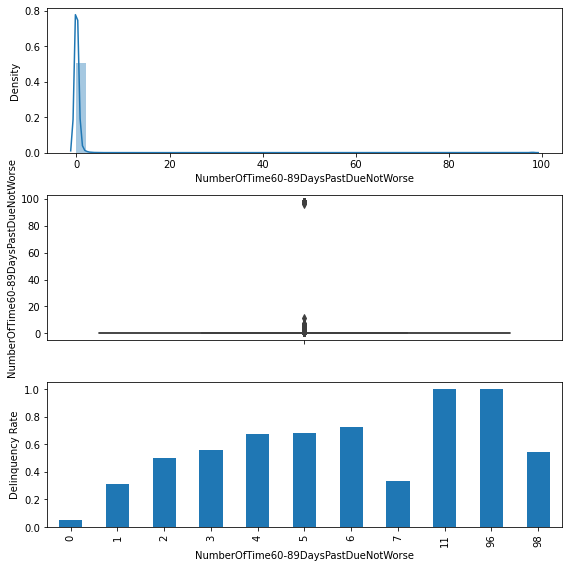

In [12]:
count_box_response('NumberOfTime60-89DaysPastDueNotWorse')

- Observations : As NumberOfTime60-89DaysPastDueNotWorse increases, delinquency rate goes up, looks like an important feature by itself, outliers behave differently, therefore 
it's best to keep them. 96 and 98 seem to be way away from the other points

#### 5. NumberOfTimes90DaysLate

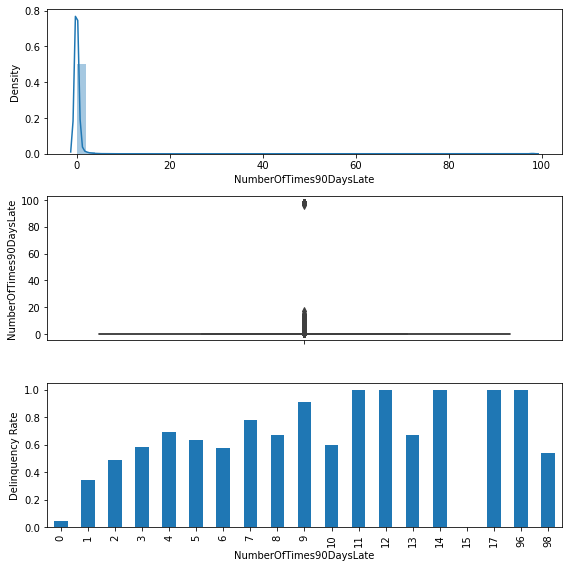

In [13]:
count_box_response('NumberOfTimes90DaysLate')

- Observations : As NumberOfTime60-89DaysPastDueNotWorse increases, delinquency rate goes up, looks like an important feature by itself, outliers behave differently, therefore 
it's best to keep them. 96 and 98 seem to be way away from the other points

#### 6. DebtRatio

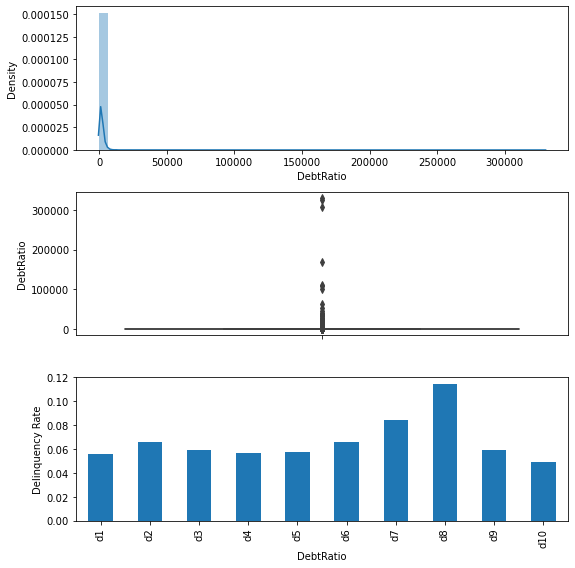

In [14]:
hist_box_response('DebtRatio')

- Observations : Not very indicative as the delinquency rate hovers near the overall rate despite changes in the value

#### 7. Monthly Income

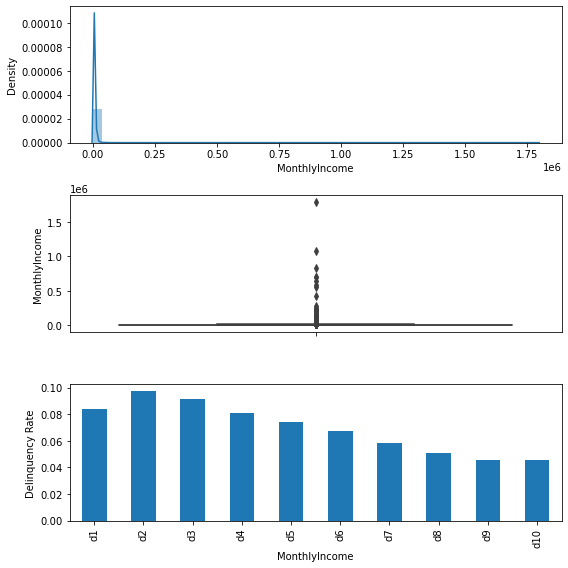

In [363]:
hist_box_response('MonthlyIncome')

-Observations : Higher the income lower the delinquency rate

#### 8. NumberofOpenCreditLineAndLoans

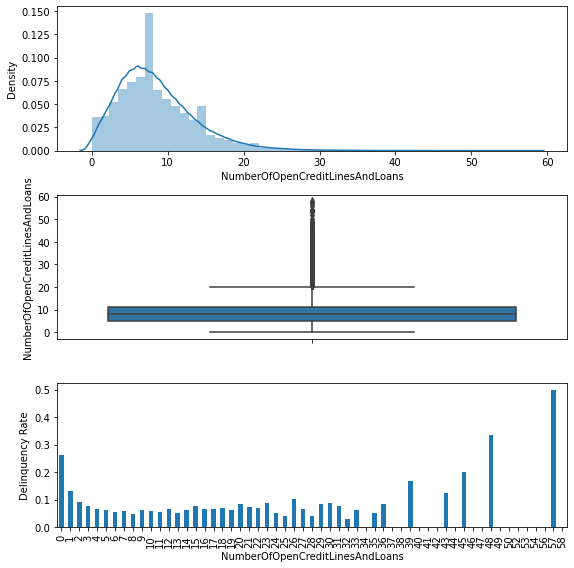

In [362]:
count_box_response('NumberOfOpenCreditLinesAndLoans')

- Observations : Interesting, two groups tend to be most delinquent, 0 and over 36 

#### 9. NumberRealEstateLoansOrLines

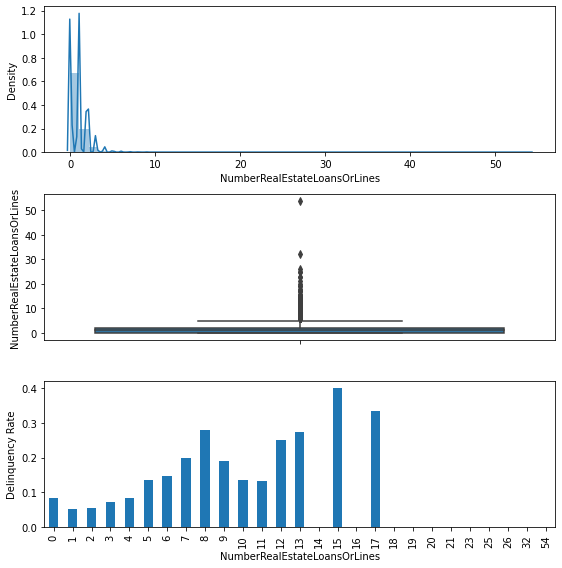

In [17]:
count_box_response('NumberRealEstateLoansOrLines')

- Observations : Delinquency increases as the number of RealEstateLoans increase

#### 10. NumberofDependents

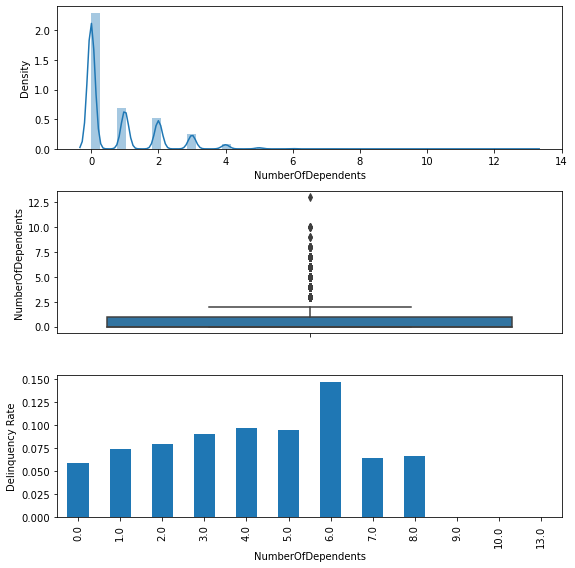

In [18]:
count_box_response('NumberOfDependents')

- Observations : Seems to stay steady, can be looked into as a part of feature engineering

 #### Summary of Univariate Analysis

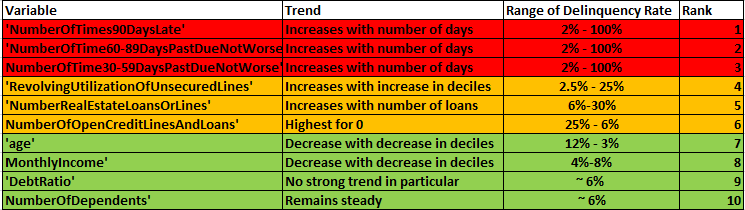

### 3.2 Data Cleaning

-Observation: For all fields measuring number of times past due, there is a commonality of 96 and 98 and their delinquency rate is also similar

In [19]:
def plotter(column):   ## helper to plot the required graphs
    
        plotter = pd.DataFrame()
        plotter[column] =  X_train[X_train[column].notnull()][column]      
        y_plot = y_train.copy()
        y_plot = y_train[X_train[column].notnull()]
        y_plot.reset_index(drop=True, inplace=True)
        plotter.reset_index(drop=True, inplace=True)
        plotter = pd.concat([plotter,y_plot],axis =1)
        plotter.groupby(column)['SeriousDlqin2yrs'].mean().plot(kind='bar');


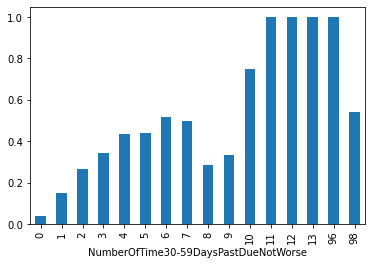

In [20]:
plotter('NumberOfTime30-59DaysPastDueNotWorse')

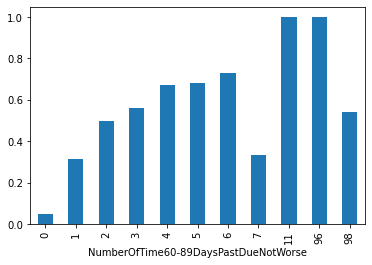

In [21]:
plotter('NumberOfTime60-89DaysPastDueNotWorse')

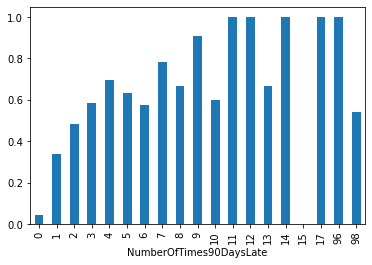

In [22]:
plotter('NumberOfTimes90DaysLate')

In [23]:
### see if they all are coming from the same records, ans : same number

print('records in NumberOfTime30-59DaysPastDueNotWorse that are irregular:',
      X_train.loc[X_train['NumberOfTime30-59DaysPastDueNotWorse'] > 90 ]['NumberOfTime30-59DaysPastDueNotWorse'].count())
print('records in NumberOfTime60-89DaysPastDueNotWorse that are irregular:',
      X_train.loc[X_train['NumberOfTime60-89DaysPastDueNotWorse'] > 90 ]['NumberOfTime60-89DaysPastDueNotWorse'].count())
print('records in NumberOfTimes90DaysLate that are irregular:',
      X_train.loc[X_train['NumberOfTimes90DaysLate'] > 90 ]['NumberOfTimes90DaysLate'].count())

records in NumberOfTime30-59DaysPastDueNotWorse that are irregular: 180
records in NumberOfTime60-89DaysPastDueNotWorse that are irregular: 180
records in NumberOfTimes90DaysLate that are irregular: 180


In [24]:
## check if they are the same recod and we aren't getting this by chance
df1 = X_train.loc[(X_train['NumberOfTime30-59DaysPastDueNotWorse']>90) & (X_train['NumberOfTime60-89DaysPastDueNotWorse'] > 90)]

In [25]:
df1 ## they are all the same rows, let's check a little more 

Unnamed: 0  RevolvingUtilizationOfUnsecuredLines  age  \
25138        25139                                   1.0   59   
32493        32494                                   1.0   43   
45368        45369                                   1.0   55   
92079        92080                                   1.0   23   
128624      128625                                   1.0   54   
...            ...                                   ...  ...   
77887        77888                                   1.0   37   
138068      138069                                   1.0   40   
24460        24461                                   1.0   21   
40863        40864                                   1.0   23   
57857        57858                                   1.0   21   

        NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
25138                                     98        0.0         2180.0   
32493                                     98       96.0            NaN   
45368                                     98        0.0            NaN   
92079                                     98        0.0            NaN   
128624                                    98        0.0            NaN   
...                                      ...        ...            ...   
77887                                     98        0.0         6000.0   
138068                                    98       49.0            NaN   
24460                                     98        0.0         2300.0   
40863                                     98        0.0         3635.0   
57857                                     98        0.0            0.0   

        NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
25138                                 0                       98   
32493                                 0                       98   
45368                                 0                       98   
92079                                 0                       98   
128624                                0                       98   
...                                 ...                      ...   
77887                                 0                       98   
138068                                0                       98   
24460                                 0                       98   
40863                                 0                       98   
57857                                 0                       98   

        NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
25138                              0                                    98   
32493                              0                                    98   
45368                              0                                    98   
92079                              0                                    98   
128624                             0                                    98   
...                              ...                                   ...   
77887                              0                                    98   
138068                             0                                    98   
24460                              0                                    98   
40863                              0                                    98   
57857                              0                                    98   

        NumberOfDependents  
25138                  0.0  
32493                  0.0  
45368                  0.0  
92079                  NaN  
128624                 NaN  
...                    ...  
77887                  1.0  
138068                 0.0  
24460                  0.0  
40863                  0.0  
57857                  0.0  

[180 rows x 11 columns]

In [26]:
df1.describe()

Unnamed: 0  RevolvingUtilizationOfUnsecuredLines         age  \
count     180.000000                          1.800000e+02  180.000000   
mean    73093.272222                          9.999999e-01   34.238889   
std     42403.360541                          3.562624e-15   13.074075   
min      1734.000000                          9.999999e-01   21.000000   
25%     34480.250000                          9.999999e-01   23.000000   
50%     70472.000000                          9.999999e-01   29.000000   
75%    108447.750000                          9.999999e-01   43.250000   
max    149770.000000                          9.999999e-01   79.000000   

       NumberOfTime30-59DaysPastDueNotWorse   DebtRatio  MonthlyIncome  \
count                            180.000000  180.000000      98.000000   
mean                              97.988889    4.924274    2443.438776   
std                                0.149071   23.695848    1856.826902   
min                               96.000000    0.000000       0.000000   
25%                               98.000000    0.000000    1273.000000   
50%                               98.000000    0.000000    2000.000000   
75%                               98.000000    0.000000    3015.000000   
max                               98.000000  255.000000    9016.000000   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                       180.000000               180.000000   
mean                          0.005556                97.988889   
std                           0.074536                 0.149071   
min                           0.000000                96.000000   
25%                           0.000000                98.000000   
50%                           0.000000                98.000000   
75%                           0.000000                98.000000   
max                           1.000000                98.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                         180.0                            180.000000   
mean                            0.0                             97.988889   
std                             0.0                              0.149071   
min                             0.0                             96.000000   
25%                             0.0                             98.000000   
50%                             0.0                             98.000000   
75%                             0.0                             98.000000   
max                             0.0                             98.000000   

       NumberOfDependents  
count          159.000000  
mean             0.364780  
std              0.859948  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000

In [27]:
y1 = y_train.loc[(X_train['NumberOfTime30-59DaysPastDueNotWorse']>90) & (X_train['NumberOfTime60-89DaysPastDueNotWorse'] > 90)]

In [28]:
y1.describe()

count    180.000000
mean       0.544444
std        0.499410
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: SeriousDlqin2yrs, dtype: float64

- There seems a lot of issues with this subset, eg: Revolving utilization is 0, most of them do not have any Credit Lines or loans or Real Estate loans. Better drop them.

- For missing values in Monthly Income and Number of Dependents:

    It's best to fill Monthly Income with Median as the distribution is right skewed
    It's best to fill Number of dependents with 0, which seems will most likely be the case. But in real world scnario
    it ould have to be confirmed with the stakeholders.

In [29]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

### 3.3 Correlation Matrix

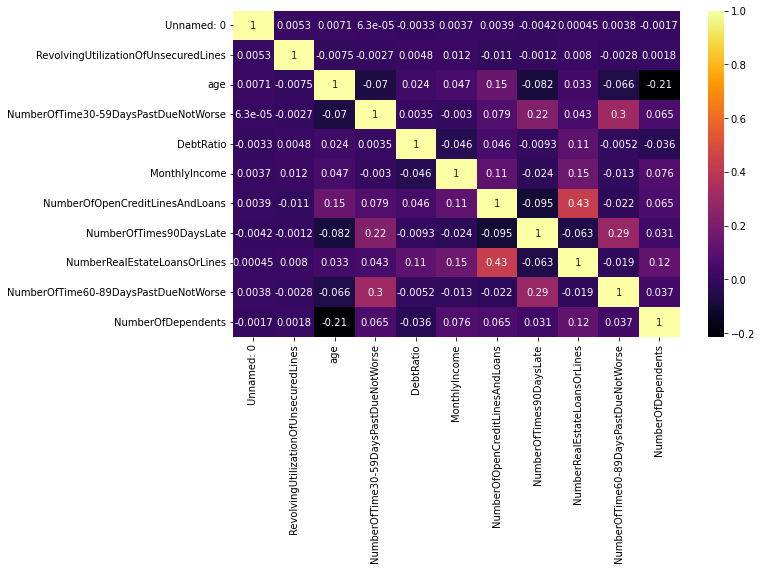

In [30]:
plt.figure(figsize=(10,6))
sns.heatmap(X_train_m.corr(), annot=True,cmap="inferno");

- Observation : 
                Number of times fields are slightly correlated
                Number of RealEstate and Credit lines are slightly correlated
                
                

### 3.4 Scaling and Preparation

In [280]:

drop_features =['Unnamed: 0']

steps = [('zero_imp',SimpleImputer(strategy= "constant", fill_value=0)),('minmax',MinMaxScaler())]
zero_imp_pipeline_2 = Pipeline(steps=steps)
zero_imp_columns = ['NumberOfDependents']

steps = [('median_imp',SimpleImputer(strategy='median')),('minmax',MinMaxScaler())]
median_imp_pipeline_2 = Pipeline(steps=steps)
median_imp_columns = ['MonthlyIncome']

steps =[('std_scal',StandardScaler())]
std_scal_pipeline = Pipeline(steps =steps)
std_scale_cols = ['age','NumberOfOpenCreditLinesAndLoans'] ## scaling standard as shape is like a bell curve

steps =[('minmaxscal',MinMaxScaler())]
minmax_scale_pipeline = Pipeline(steps=steps)
minmax_scale_cols =['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 
                    'DebtRatio', 'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines', ## scaling minmax as not bell shaped
                    'NumberOfTime60-89DaysPastDueNotWorse']

transformers = [('drop_columns', 'drop', drop_features),
                         ('zeroimp',zero_imp_pipeline_2,zero_imp_columns),
                         ('medianimp',median_imp_pipeline_2,median_imp_columns),
                         ( 'stdscale',std_scal_pipeline,std_scale_cols),
                          ('minmaxscale',minmax_scale_pipeline,minmax_scale_cols)]
imp_scale_transformer = ColumnTransformer(transformers=transformers)
column_names =[]
for name, estimator, features in imp_scale_transformer.transformers[1:] :
    column_names += features



In [32]:
X_train_m = imp_scale_transformer.fit_transform(X_train_m)

In [33]:
X_train_m = pd.DataFrame(X_train_m, columns=column_names)

In [35]:
X_train_m

NumberOfDependents  MonthlyIncome       age  \
0                 0.076923       0.003335 -1.511708   
1                 0.000000       0.001561 -0.833784   
2                 0.000000       0.002620 -1.240538   
3                 0.000000       0.003000  2.081288   
4                 0.153846       0.002973  0.589856   
...                    ...            ...       ...   
100315            0.000000       0.006948 -0.291445   
100316            0.000000       0.004289 -0.765992   
100317            0.076923       0.004784 -0.223653   
100318            0.000000       0.000856  0.725441   
100319            0.000000       0.003000 -0.765992   

        NumberOfOpenCreditLinesAndLoans  RevolvingUtilizationOfUnsecuredLines  \
0                             -0.676859                          3.625106e-06   
1                             -1.259951                          1.052089e-05   
2                             -1.454315                          2.025316e-05   
3                             -0.871223                          3.411651e-07   
4                             -1.065587                          1.345862e-05   
...                                 ...                                   ...   
100315                         0.878054                          0.000000e+00   
100316                         0.100598                          8.156851e-08   
100317                         1.849875                          0.000000e+00   
100318                        -1.259951                          1.824539e-05   
100319                        -1.065587                          1.972075e-05   

        NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  \
0                                   0.000000  5.358113e-07   
1                                   0.000000  4.429337e-07   
2                                   0.000000  1.987417e-07   
3                                   0.000000  5.763444e-05   
4                                   0.000000  4.253800e-07   
...                                      ...           ...   
100315                              0.000000  1.854537e-06   
100316                              0.000000  1.432741e-06   
100317                              0.000000  9.777953e-07   
100318                              0.000000  1.182944e-06   
100319                              0.076923  2.626917e-03   

        NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
0                      0.000000                      0.037037   
1                      0.000000                      0.000000   
2                      0.000000                      0.000000   
3                      0.000000                      0.000000   
4                      0.000000                      0.000000   
...                         ...                           ...   
100315                 0.000000                      0.111111   
100316                 0.000000                      0.037037   
100317                 0.000000                      0.018519   
100318                 0.058824                      0.000000   
100319                 0.000000                      0.000000   

        NumberOfTime60-89DaysPastDueNotWorse  
0                                   0.000000  
1                                   0.000000  
2                                   0.000000  
3                                   0.000000  
4                                   0.000000  
...                                      ...  
100315                              0.000000  
100316                              0.000000  
100317                              0.000000  
100318                              0.000000  
100319                              0.090909  

[100320 rows x 10 columns]

-X_train_m is now scaled

## 3. Establishing the Metrics Relevant

- Since we are predicting delinquency, it is importatnt that we catch as many cases where there is a possibility of delinquency.
- Just accuracy will not serve the purpose as we might miss many cases where there is a high chance of delinquency, but we    predict all cases of non delinquency correctly.
- Therefore the right metric to choose would be class 1 recall. A high class 1 recall would mean that we would have low False Negtives in cases where the accounts were predicted delinquent.
- The drawback to this approach would be that we might face a high rate of False Positives, but that would be better than missing the delinquent accounts. The model could work in conjunction with bank workers to make a better decision

## 4. Feature Engineering

Let's try 3 features:
                a) Total times late
                b) Monthly Income per dependents
                c) Revolving Utilization / Debt Ratio

In [300]:
y = data['SeriousDlqin2yrs']
X = data.drop(columns=['SeriousDlqin2yrs'])

## because the number of times fields are highly correlated
X['Total Times Due'] = X['NumberOfTime30-59DaysPastDueNotWorse'] + X['NumberOfTime60-89DaysPastDueNotWorse']\
                      +X['NumberOfTimes90DaysLate']
## Engineered features based on features that were low in the list of EDA
    
X['Monthly Income per person'] = X['MonthlyIncome']/(X['NumberOfDependents'] + 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify =y)





- Let's see the response of these features with the target

 #### a) Total times Due

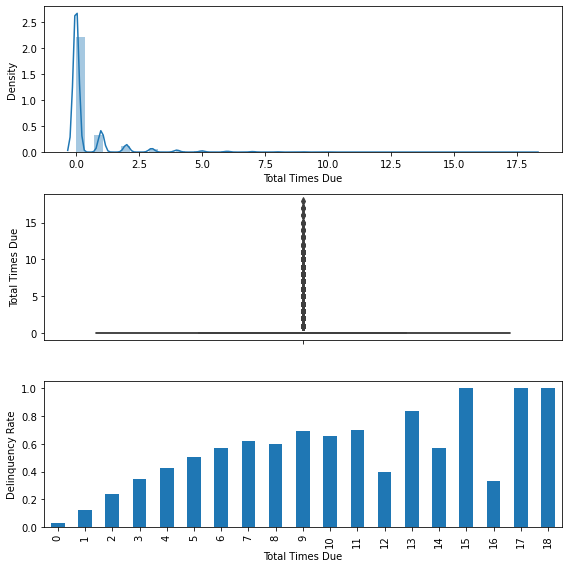

In [53]:
count_box_response('Total Times Due')

 #### b) Monthly Income per person

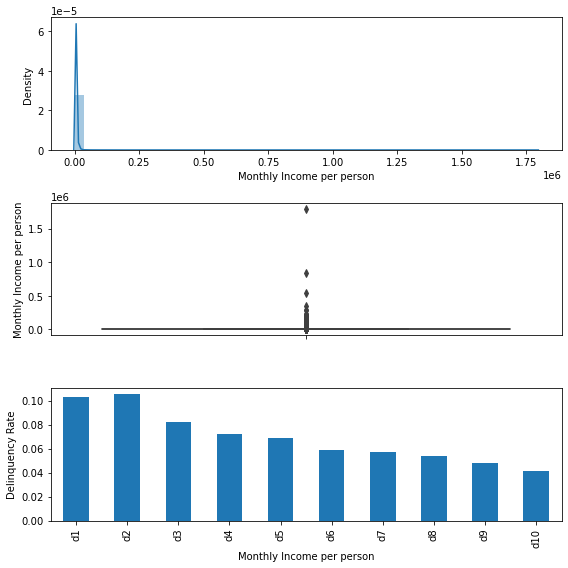

In [54]:
hist_box_response('Monthly Income per person')

- See some correlation, higher the variable lower the delinquency

## 4. Model Selection

####  a) Baseline model XGBoost without any feature engineered features

In [36]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train 
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

### train test split for modelling purposes

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
steps =[('preprocess',imp_scale_transformer), 
        ('xgb', XGBClassifier(n_jobs=-1))]

model_xgb_base_pipeline = Pipeline(steps=steps)

In [38]:
model_xgb_base_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['Unnamed: 0']),
                                                 ('zeroimp',
                                                  Pipeline(steps=[('zero_imp',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['NumberOfDependents']),
                                                 ('medianimp',
                                                  Pipeline(steps=[('median_imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['Mon...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [37]:
model_xgb_base_pipeline.fit(X_train_b,y_train_b)
y_pred = model_xgb_base_pipeline.predict(X_test_b)
print(classification_report(y_test_b, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     30922
           1       0.56      0.17      0.27      2184

    accuracy                           0.94     33106
   macro avg       0.75      0.58      0.62     33106
weighted avg       0.92      0.94      0.92     33106



- Has a very poor class 1 recall score we need to improve on it.

####  b) Modelling after feature Engineering

#### Preprocessing  the data

In [323]:
drop_features =['Unnamed: 0']

steps = [('zero_imp',SimpleImputer(strategy= "constant", fill_value=0)),('minmax',MinMaxScaler())]
zero_imp_pipeline_2 = Pipeline(steps=steps)
zero_imp_columns = ['NumberOfDependents','Monthly Income per person']

steps = [('median_imp',SimpleImputer(strategy='median')),('minmax',MinMaxScaler())]
median_imp_pipeline_2 = Pipeline(steps=steps)
median_imp_columns = ['MonthlyIncome']

steps =[('std_scal',StandardScaler())]
std_scal_pipeline = Pipeline(steps =steps)
std_scale_cols = ['age','NumberOfOpenCreditLinesAndLoans'] ## scaling standard as shape is like a bell curve

steps =[('minmaxscal',MinMaxScaler())]
minmax_scale_pipeline = Pipeline(steps=steps)
minmax_scale_cols =['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 
                    'DebtRatio', 'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines', ## scaling minmax as not bell shaped
                    'NumberOfTime60-89DaysPastDueNotWorse','Total Times Due']

transformers = [('drop_columns', 'drop', drop_features),
                         ('zeroimp',zero_imp_pipeline_2,zero_imp_columns),
                         ('medianimp',median_imp_pipeline_2,median_imp_columns),
                         ( 'stdscale',std_scal_pipeline,std_scale_cols),
                          ('minmaxscale',minmax_scale_pipeline,minmax_scale_cols)]
imp_scale_transformer = ColumnTransformer(transformers=transformers)
column_names =[]
for name, estimator, features in imp_scale_transformer.transformers[1:] :
    column_names += features

In [54]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('lr', LogisticRegression())]

model_lr2_pipeline = Pipeline(steps=steps)

#### a)   Modelling Logistic regression model after Feature Engineering

In [55]:
model_lr2_pipeline.fit(X_train_b,y_train_b)
y_pred = model_lr2_pipeline.predict(X_test_b)
print(classification_report(y_test_b, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     30922
           1       0.26      0.62      0.37      2184

    accuracy                           0.86     33106
   macro avg       0.62      0.75      0.64     33106
weighted avg       0.92      0.86      0.88     33106



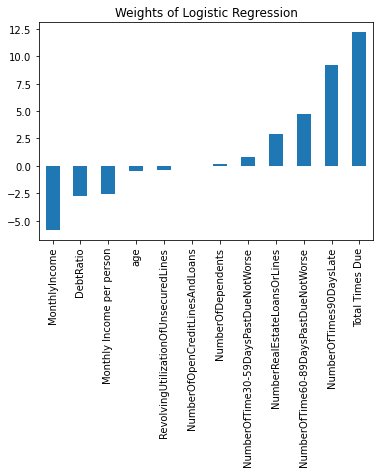

In [56]:
column_names =[]
for name, estimator, features in model_lr2_pipeline.named_steps['preprocess'].transformers[1:] :
    column_names += features
pd.Series(model_lr2_pipeline.named_steps['lr'].coef_[0],index=column_names).sort_values().plot(kind='bar')
plt.title("Weights of Logistic Regression");

- Engineered Features show some importance. Intersetingly monthly income comes out as important, even though it didn't show up
important during the EDA. Revolving Utilization and Number of Credit Lines show bearly no importance which were quite significant in the EDA. Let's try another model.

#### b)   Modelling XGBoost model after feature engineering

In [57]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('xgb', XGBClassifier(n_jobs=-1))]

model_xgb2_pipeline = Pipeline(steps=steps)

In [58]:
model_xgb2_pipeline.fit(X_train_b,y_train_b)
y_pred = model_xgb2_pipeline.predict(X_test_b)
print(classification_report(y_test_b, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91     30922
           1       0.24      0.66      0.36      2184

    accuracy                           0.84     33106
   macro avg       0.61      0.76      0.63     33106
weighted avg       0.92      0.84      0.87     33106



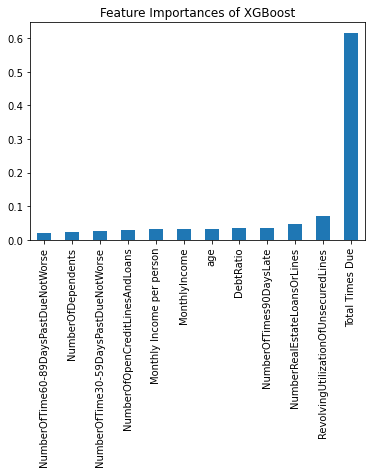

In [59]:
column_names =[]
for name, estimator, features in model_xgb2_pipeline.named_steps['preprocess'].transformers[1:] :
    column_names += features
pd.Series(model_xgb2_pipeline.named_steps['xgb'].feature_importances_,index=column_names).sort_values().plot(kind='bar')
plt.title("Feature Importances of XGBoost");

- Total times due comes out as extremely important, the second most important feature is utilization, followed by
number of real estate loans.Let's try another model.

#### c)  Modelling RFC model after feature engineering

In [61]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train 
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('rfc', RandomForestClassifier())]

model_rfc2_pipeline = Pipeline(steps=steps)

In [62]:
model_rfc2_pipeline.fit(X_train_b,y_train_b)
y_pred = model_rfc2_pipeline.predict(X_test_b)
print(classification_report(y_test_b, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     30922
           1       0.45      0.24      0.32      2184

    accuracy                           0.93     33106
   macro avg       0.70      0.61      0.64     33106
weighted avg       0.92      0.93      0.92     33106



- Not a good model, has a poor score for the required metric

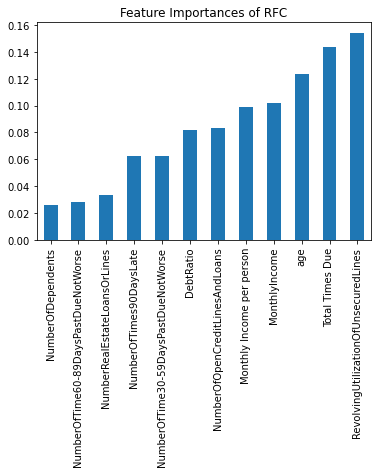

In [63]:
column_names =[]
for name, estimator, features in model_rfc2_pipeline.named_steps['preprocess'].transformers[1:] :
    column_names += features
pd.Series(model_rfc2_pipeline.named_steps['rfc'].feature_importances_,index=column_names).sort_values().plot(kind='bar')
plt.title("Feature Importances of RFC");

### Let's now parameter tune the models to optimize them for recall score for class 1

### a.1) Hyperparameter tune the XGB model

In [65]:

steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('xgb', XGBClassifier(n_jobs=-1))]


pipe=Pipeline(steps=steps)

parameters = {  
  'xgb__max_depth': [2, 4, 6, 8], 
  'xgb__gamma' : [0,0.5,1],
  'xgb__subsample': [0.3,0.8,1],
  'xgb__colsample_bytree': [0.3,0.8,1]}



In [66]:
modified_recall = make_scorer(recall_score,labels=[1]) ## scoring to give importance to recall for class 1

In [67]:
grid_model=RandomizedSearchCV(pipe,param_distributions=parameters,cv=3,scoring=modified_recall,n_jobs=-1,verbose = 3)

In [68]:
grid_model.fit(X_train_b,y_train_b)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('drop_columns',
                                                                               'drop',
                                                                               ['Unnamed: '
                                                                                '0']),
                                                                              ('zeroimp',
                                                                               Pipeline(steps=[('zero_imp',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant')),
                                                                                               ('minmax',
                                                                                                MinMaxScaler())]),
                                                                               ['NumberOfDependents',
                                                                                'Monthly '
                                                                                'Income '
                                                                                'per '
                                                                                'person']),
                                                                              ('medianimp',
                                                                               Pipeline(steps=[('median_imp',...
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            n_estimators=100,
                                                            n_jobs=-1,
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.3, 0.8, 1],
                                        'xgb__gamma': [0, 0.5, 1],
                                        'xgb__max_depth': [2, 4, 6, 8],
                                        'xgb__subsample': [0.3, 0.8, 1]},
                   scoring=make_scorer(recall_score, labels=[1]), verbose=3)

In [69]:
grid_model.best_params_


{'xgb__subsample': 0.8,
 'xgb__max_depth': 2,
 'xgb__gamma': 0,
 'xgb__colsample_bytree': 0.8}

In [70]:
y_pred=grid_model.predict(X_test_b)
print(classification_report(y_test_b,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     30922
           1       0.21      0.76      0.33      2184

    accuracy                           0.80     33106
   macro avg       0.60      0.78      0.61     33106
weighted avg       0.93      0.80      0.84     33106



- Recall score drastically improved, let's see which features are important for this model

In [71]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('xgb', XGBClassifier(subsample=0.8,max_depth=2,gamma=0,colsample_bytree=0.8,n_jobs=-1))]
model_xgb3_pipeline = Pipeline(steps=steps)

In [72]:
model_xgb3_pipeline.fit(X_train_b,y_train_b)
y_pred = model_xgb3_pipeline.predict(X_test_b)
print(classification_report(y_test_b, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     30922
           1       0.21      0.77      0.33      2184

    accuracy                           0.80     33106
   macro avg       0.60      0.78      0.61     33106
weighted avg       0.93      0.80      0.84     33106



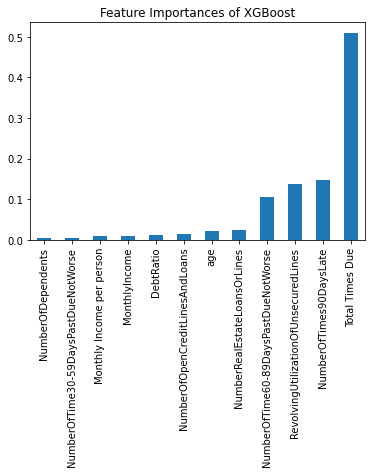

In [73]:
column_names =[]
for name, estimator, features in model_xgb3_pipeline.named_steps['preprocess'].transformers[1:] :
    column_names += features
pd.Series(model_xgb3_pipeline.named_steps['xgb'].feature_importances_,index=column_names).sort_values().plot(kind='bar')
plt.title("Feature Importances of XGBoost");

- Similar profile to initial XGB but more weightage to Revolving utilization

### a.2) Hyperparameter tune the LR model

In [75]:
cvals = [0.0001,
         0.000774263682681127,
         0.005994842503189409,
         0.046415888336127774,
         0.3593813663804626,
         1,
         2.782559402207126,
         21.54434690031882,
         166.81005372000558,
         1291.5496650148827,
         10000.0]

In [76]:
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('lr', LogisticRegression())]


pipe=Pipeline(steps=steps)

parameters = {  
  'lr__penalty': ['l1', 'l2','elasticnet'], 
  'lr__C' : cvals,
  }

In [77]:
modified_recall = make_scorer(recall_score,labels=[1])

In [78]:
grid_model=GridSearchCV(pipe,param_grid=parameters,cv=3,scoring=modified_recall,n_jobs=-1,verbose = 3)

In [80]:
grid_model.fit(X_train_b,y_train_b)

Fitting 3 folds for each of 33 candidates, totalling 99 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         'drop',
                                                                         ['Unnamed: '
                                                                          '0']),
                                                                        ('zeroimp',
                                                                         Pipeline(steps=[('zero_imp',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['NumberOfDependents',
                                                                          'Monthly '
                                                                          'Income '
                                                                          'per '
                                                                          'person']),
                                                                        ('medianimp',
                                                                         Pipeline(steps=[('median_imp',
                                                                                          Simple...
                                       ('ros', RandomOverSampler()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': [0.0001, 0.000774263682681127,
                                   0.005994842503189409, 0.046415888336127774,
                                   0.3593813663804626, 1, 2.782559402207126,
                                   21.54434690031882, 166.81005372000558,
                                   1291.5496650148827, 10000.0],
                         'lr__penalty': ['l1', 'l2', 'elasticnet']},
             scoring=make_scorer(recall_score, labels=[1]), verbose=3)

In [81]:
grid_model.best_params_

{'lr__C': 0.000774263682681127, 'lr__penalty': 'l2'}

In [82]:
y_pred=grid_model.predict(X_test_b)
print(classification_report(y_test_b,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.66      0.79     30922
           1       0.12      0.66      0.21      2184

    accuracy                           0.66     33106
   macro avg       0.54      0.66      0.50     33106
weighted avg       0.91      0.66      0.75     33106



- Recall score improved from the previous one, let's see which features come out important

In [83]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('lr', LogisticRegression(penalty ='l2',C = 0.000774263682681127))]
model_lr3_pipeline = Pipeline(steps=steps)

In [84]:
model_lr3_pipeline.fit(X_train_b,y_train_b)
y_pred = model_lr3_pipeline.predict(X_test_b)
print(classification_report(y_test_b, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.66      0.79     30922
           1       0.12      0.66      0.21      2184

    accuracy                           0.66     33106
   macro avg       0.54      0.66      0.50     33106
weighted avg       0.91      0.66      0.75     33106



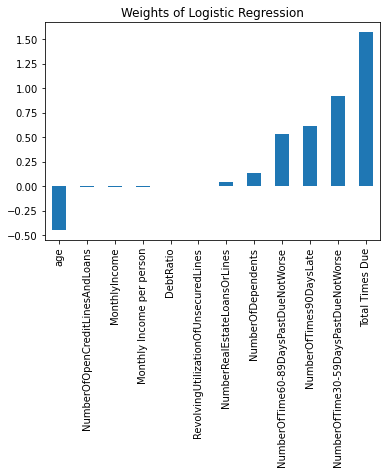

In [85]:
column_names =[]
for name, estimator, features in model_lr3_pipeline.named_steps['preprocess'].transformers[1:] :
    column_names += features
pd.Series(model_lr3_pipeline.named_steps['lr'].coef_[0],index=column_names).sort_values().plot(kind='bar')
plt.title("Weights of Logistic Regression");

- Interestingly only the Number of days features are most important, but age which is one of the lower importance features, shows up as important

### a.3) Hyperparameter tune the RFC model

In [86]:
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('rfc', RandomForestClassifier())]


pipe=Pipeline(steps=steps)

parameters = {
             'rfc__max_depth': [5,10, 20, 30, 40, 50, None],
             'rfc__max_features': ['auto', 'sqrt'],
             'rfc__min_samples_leaf': [1, 2, 4],
             'rfc__min_samples_split': [2, 5, 10],
             'rfc__n_estimators': [50,100, 200]}

In [87]:
modified_recall = make_scorer(recall_score,labels=[1])

In [88]:
grid_model=RandomizedSearchCV(pipe,param_distributions=parameters,cv=3,scoring=modified_recall,verbose = 3)

In [89]:
grid_model.fit(X_train_b,y_train_b)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END rfc__max_depth=40, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=100;, score=0.358 total time=  11.2s
[CV 2/3] END rfc__max_depth=40, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=100;, score=0.333 total time=  11.0s
[CV 3/3] END rfc__max_depth=40, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=100;, score=0.362 total time=  11.0s
[CV 1/3] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=50;, score=0.260 total time=   5.4s
[CV 2/3] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=50;, score=0.235 total time=   5.3s
[CV 3/3] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('drop_columns',
                                                                               'drop',
                                                                               ['Unnamed: '
                                                                                '0']),
                                                                              ('zeroimp',
                                                                               Pipeline(steps=[('zero_imp',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant')),
                                                                                               ('minmax',
                                                                                                MinMaxScaler())]),
                                                                               ['NumberOfDependents',
                                                                                'Monthly '
                                                                                'Income '
                                                                                'per '
                                                                                'person']),
                                                                              ('medianimp',
                                                                               Pipeline(steps=[('median_imp',...
                                                                                'NumberOfTime60-89DaysPastDueNotWorse',
                                                                                'Total '
                                                                                'Times '
                                                                                'Due'])])),
                                             ('ros', RandomOverSampler()),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   param_distributions={'rfc__max_depth': [5, 10, 20, 30, 40,
                                                           50, None],
                                        'rfc__max_features': ['auto', 'sqrt'],
                                        'rfc__min_samples_leaf': [1, 2, 4],
                                        'rfc__min_samples_split': [2, 5, 10],
                                        'rfc__n_estimators': [50, 100, 200]},
                   scoring=make_scorer(recall_score, labels=[1]), verbose=3)

In [90]:
y_pred=grid_model.predict(X_test_b)
print(classification_report(y_test_b,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91     30922
           1       0.26      0.67      0.37      2184

    accuracy                           0.85     33106
   macro avg       0.61      0.76      0.64     33106
weighted avg       0.93      0.85      0.88     33106



- Recall score greatly improved, let's see which features are now important

In [91]:
grid_model.best_params_

{'rfc__n_estimators': 50,
 'rfc__min_samples_split': 10,
 'rfc__min_samples_leaf': 4,
 'rfc__max_features': 'auto',
 'rfc__max_depth': 10}

In [92]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('rfc', RandomForestClassifier(n_estimators =50,min_samples_split=10,min_samples_leaf=4,max_features='auto',max_depth=10))]
model_rfc3_pipeline = Pipeline(steps=steps)

In [93]:
model_rfc3_pipeline.fit(X_train_b,y_train_b)
y_pred = model_rfc3_pipeline.predict(X_test_b)
print(classification_report(y_test_b, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92     30922
           1       0.26      0.65      0.37      2184

    accuracy                           0.86     33106
   macro avg       0.62      0.76      0.65     33106
weighted avg       0.93      0.86      0.88     33106



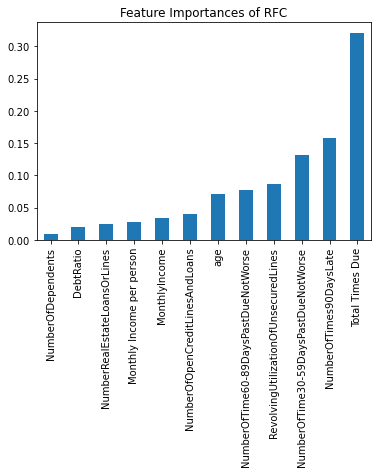

In [94]:
column_names =[]
for name, estimator, features in model_rfc3_pipeline.named_steps['preprocess'].transformers[1:] :
    column_names += features
pd.Series(model_rfc3_pipeline.named_steps['rfc'].feature_importances_,index=column_names).sort_values().plot(kind='bar')
plt.title("Feature Importances of RFC");

- Total time due is the most important and gives some importance to utilization

### 4.3 Stacking the Best models of RFC and LR

- Since LR and RFC give different importances to different features,let's see if stacking them improves the model

In [95]:
estimators = [
    ('lr3',  LogisticRegression(penalty ='l2',C = 0.000774263682681127) ),   
    ('rfc3', RandomForestClassifier(n_estimators =100,min_samples_split=10,min_samples_leaf=4,max_features='auto',max_depth=10)),  
             ]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())
    
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('stackedclassifier',clf )]
    
stack_pipeline = Pipeline(steps=steps)

In [96]:
stack_pipeline.fit(X_train_b,y_train_b)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['Unnamed: 0']),
                                                 ('zeroimp',
                                                  Pipeline(steps=[('zero_imp',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['NumberOfDependents',
                                                   'Monthly Income per '
                                                   'person']),
                                                 ('medianimp',
                                                  Pipeline(steps=[('median_imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minm...
                                                   'NumberRealEstateLoansOrLines',
                                                   'NumberOfTime60-89DaysPastDueNotWorse',
                                                   'Total Times Due'])])),
                ('ros', RandomOverSampler()),
                ('stackedclassifier',
                 StackingClassifier(estimators=[('lr3',
                                                 LogisticRegression(C=0.000774263682681127)),
                                                ('rfc3',
                                                 RandomForestClassifier(max_depth=10,
                                                                        max_features='auto',
                                                                        min_samples_leaf=4,
                                                                        min_samples_split=10))],
                                    final_estimator=LogisticRegression()))])

In [97]:
y_pred = stack_pipeline.predict(X_test_b)
print(classification_report(y_test_b, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91     30922
           1       0.25      0.68      0.36      2184

    accuracy                           0.84     33106
   macro avg       0.61      0.77      0.64     33106
weighted avg       0.93      0.84      0.87     33106



- Improved the recall score as compared to the individual models but not as good as XGBoost. Let us proceed with XGBoost as the final model.

## 5. Feature Selection with XGB

- Since XGBoost predicted with the best score, let us try and find the best features

Let's drop the Number of times fields and only keep the Total times due and see how the model performs

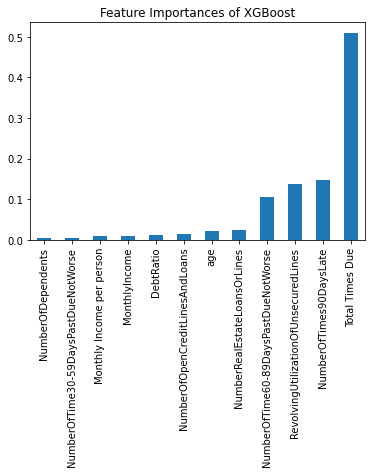

In [98]:
pd.Series(model_xgb3_pipeline.named_steps['xgb'].feature_importances_,index=column_names).sort_values().plot(kind='bar')
plt.title("Feature Importances of XGBoost");

In [99]:
drop_features =['Unnamed: 0','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse']

steps = [('zero_imp',SimpleImputer(strategy= "constant", fill_value=0)),('minmax',MinMaxScaler())]
zero_imp_pipeline_2 = Pipeline(steps=steps)
zero_imp_columns = ['NumberOfDependents','Monthly Income per person']

steps = [('median_imp',SimpleImputer(strategy='median')),('minmax',MinMaxScaler())]
median_imp_pipeline_2 = Pipeline(steps=steps)
median_imp_columns = ['MonthlyIncome']

steps =[('std_scal',StandardScaler())]
std_scal_pipeline = Pipeline(steps =steps)
std_scale_cols = ['age','NumberOfOpenCreditLinesAndLoans'] ## scaling standard as shape is like a bell curve

steps =[('minmaxscal',MinMaxScaler())]
minmax_scale_pipeline = Pipeline(steps=steps)
minmax_scale_cols =['RevolvingUtilizationOfUnsecuredLines',  
                    'DebtRatio', 'NumberRealEstateLoansOrLines', ## scaling minmax as not bell shaped
                    'Total Times Due']

transformers = [('drop_columns', 'drop', drop_features),
                         ('zeroimp',zero_imp_pipeline_2,zero_imp_columns),
                         ('medianimp',median_imp_pipeline_2,median_imp_columns),
                         ( 'stdscale',std_scal_pipeline,std_scale_cols),
                          ('minmaxscale',minmax_scale_pipeline,minmax_scale_cols)]
imp_scale_transformer = ColumnTransformer(transformers=transformers)
column_names =[]
for name, estimator, features in imp_scale_transformer.transformers[1:] :
    column_names += features

In [100]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('xgb', XGBClassifier(subsample=0.8,max_depth=2,gamma=0,colsample_bytree=0.8,n_jobs=-1))]
model_xgb3_pipeline = Pipeline(steps=steps)

In [101]:
model_xgb3_pipeline.fit(X_train_b,y_train_b)
y_pred = model_xgb3_pipeline.predict(X_test_b)
print(classification_report(y_test_b, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     30922
           1       0.21      0.76      0.33      2184

    accuracy                           0.79     33106
   macro avg       0.59      0.78      0.60     33106
weighted avg       0.93      0.79      0.84     33106



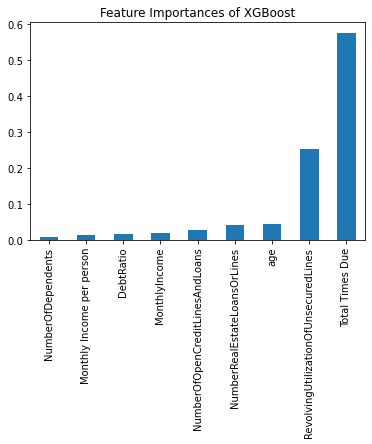

In [102]:
column_names =[]
for name, estimator, features in model_xgb3_pipeline.named_steps['preprocess'].transformers[1:] :
    column_names += features
pd.Series(model_xgb3_pipeline.named_steps['xgb'].feature_importances_,index=column_names).sort_values().plot(kind='bar')
plt.title("Feature Importances of XGBoost");

- Recall score is almost the same, at the same time it is more explainable . Let's proceed with this.


## 5. Predictions on the Test Set

In [103]:
model_xgb3_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['Unnamed: 0',
                                                   'NumberOfTime30-59DaysPastDueNotWorse',
                                                   'NumberOfTimes90DaysLate',
                                                   'NumberOfTime60-89DaysPastDueNotWorse']),
                                                 ('zeroimp',
                                                  Pipeline(steps=[('zero_imp',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['NumberOfDependents',
                                                   'Monthly...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=2, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [105]:
y_pred = model_xgb3_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     46151
           1       0.21      0.77      0.33      3260

    accuracy                           0.80     49411
   macro avg       0.60      0.78      0.61     49411
weighted avg       0.93      0.80      0.84     49411



- Model performs as well on the test set, hence it doesn't exhibit high variance
- The recall score for Class 1 is 77% which is good. It means out of all the delinquent accounts, model catches 77% of them.
- The downside is out of all the predictions the model says is delinquent, 21% are actually delinquent. This is where human intervention would be ideal.

- Therefore the model acts a good first pass for finding potential delinquent accounts.

## 6. Local Model Interpretation

In [106]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
X_train_b = imp_scale_transformer.fit_transform(X_train_b)
X_train_b = pd.DataFrame(X_train_b, columns=column_names)
X_train_b ### transform the records to be able to feed into lime

NumberOfDependents  Monthly Income per person  MonthlyIncome       age  \
0                0.076923                   0.001951       0.003902 -0.019421   
1                0.000000                   0.002176       0.002176 -0.289704   
2                0.000000                   0.006057       0.006057 -0.289704   
3                0.076923                   0.002355       0.004710 -0.424846   
4                0.000000                   0.000000       0.000000  1.467139   
...                   ...                        ...            ...       ...   
67209            0.000000                   0.002508       0.002508 -1.235697   
67210            0.000000                   0.000000       0.002995  1.534710   
67211            0.000000                   0.003679       0.003679  0.048150   
67212            0.076923                   0.000000       0.002995  1.129285   
67213            0.000000                   0.002787       0.002787 -1.303268   

       NumberOfOpenCreditLinesAndLoans  RevolvingUtilizationOfUnsecuredLines  \
0                            -0.484245                          1.862386e-05   
1                            -0.873788                          1.347839e-05   
2                             0.684384                          1.339286e-05   
3                            -1.263331                          1.771168e-05   
4                             0.684384                          8.196451e-07   
...                                ...                                   ...   
67209                        -0.289474                          7.038958e-07   
67210                        -0.679017                          3.201863e-06   
67211                         0.100069                          2.884823e-07   
67212                        -0.094702                          4.590187e-08   
67213                        -1.263331                          1.972075e-05   

          DebtRatio  NumberRealEstateLoansOrLines  Total Times Due  
0      1.003476e-06                       0.03125         0.000000  
1      3.923829e-07                       0.00000         0.000000  
2      1.299945e-06                       0.06250         0.000000  
3      5.010785e-07                       0.03125         0.055556  
4      3.003058e-04                       0.00000         0.055556  
...             ...                           ...              ...  
67209  7.177432e-07                       0.00000         0.000000  
67210  9.955591e-03                       0.06250         0.000000  
67211  5.073268e-07                       0.03125         0.000000  
67212  4.352917e-03                       0.03125         0.055556  
67213  3.299670e-07                       0.00000         0.055556  

[67214 rows x 9 columns]

In [107]:
explainer = LimeTabularExplainer(X_train_b.values,
                                 feature_names=X_train_b.columns.tolist(),
                                 class_names=['Not Delinquent', 'Delinquent'])

In [109]:
exp = explainer.explain_instance(X_train_b.loc[24], model_xgb3_pipeline['xgb'].predict_proba)
exp.show_in_notebook()

- The issue here is that since we have scaled the values, the numbers for the features become less interpretable. We will have to inverse transform the transformations. Let's see how XGBoost does without scaling.

In [198]:
drop_features =['Unnamed: 0','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse']

steps = [('zero_imp',SimpleImputer(strategy= "constant", fill_value=0))]
zero_imp_pipeline_2 = Pipeline(steps=steps)
zero_imp_columns = ['NumberOfDependents','Monthly Income per person']

steps = [('median_imp',SimpleImputer(strategy='median'))]
median_imp_pipeline_2 = Pipeline(steps=steps)
median_imp_columns = ['MonthlyIncome']

steps =[('std_scal',)]
std_scal_pipeline = Pipeline(steps =steps)
std_scale_cols = ['age','NumberOfOpenCreditLinesAndLoans'] ## scaling standard as shape is like a bell curve

steps =[('minmaxscal',MinMaxScaler())]
minmax_scale_pipeline = Pipeline(steps=steps)
minmax_scale_cols =['RevolvingUtilizationOfUnsecuredLines',  
                    'DebtRatio', 'NumberRealEstateLoansOrLines', ## scaling minmax as not bell shaped
                    'Total Times Due']

transformers = [('drop_columns', 'drop', drop_features),
                         ('zeroimp',zero_imp_pipeline_2,zero_imp_columns),
                         ('medianimp',median_imp_pipeline_2,median_imp_columns)]
#                          ( 'stdscale',std_scal_pipeline,std_scale_cols),
#                           ('minmaxscale',minmax_scale_pipeline,minmax_scale_cols)]
imp_scale_transformer = ColumnTransformer(transformers=transformers,remainder = 'passthrough')
column_names =[]
for name, estimator, features in imp_scale_transformer.transformers[1:] :
    column_names += features
    
column_names = column_names + ['RevolvingUtilizationOfUnsecuredLines','age','DebtRatio','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines',  
                               'Total Times Due']

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify =y)

In [200]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('xgb', XGBClassifier(subsample=0.8,max_depth=2,gamma=0,colsample_bytree=0.8,n_jobs=-1))]
model_xgb4_pipeline = Pipeline(steps=steps)

In [201]:
model_xgb4_pipeline.fit(X_train_b,y_train_b)
y_pred = model_xgb4_pipeline.predict(X_test_b)
print(classification_report(y_test_b, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     30922
           1       0.21      0.76      0.33      2184

    accuracy                           0.79     33106
   macro avg       0.59      0.78      0.60     33106
weighted avg       0.93      0.79      0.84     33106



- We got the same score with scaling, so finally let's interpret the results

#### Running the model on test set

In [202]:
model_xgb4_pipeline.fit(X_train,y_train)
y_pred = model_xgb4_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.79      0.87     46151
           1       0.21      0.78      0.33      3260

    accuracy                           0.79     49411
   macro avg       0.59      0.78      0.60     49411
weighted avg       0.93      0.79      0.84     49411



Same results as above

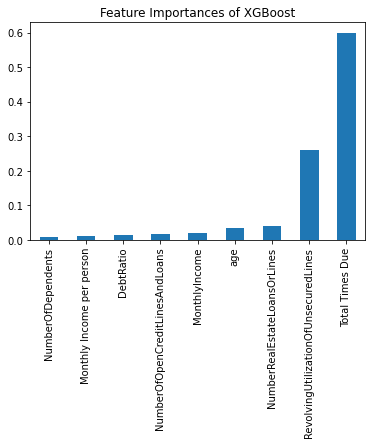

In [203]:

pd.Series(model_xgb4_pipeline.named_steps['xgb'].feature_importances_,index=column_names).sort_values().plot(kind='bar')
plt.title("Feature Importances of XGBoost");

-XGBoost does well without scaling, let's now try and interpret the model

In [221]:
column_names = ['Num Dep','MonthInc/per','MonthInc','RevUtil','age','DebtRatio','NOCL','NORL','TotalTimesDue']

In [222]:
imp_scale_transformer.fit(X_train)
X_test = imp_scale_transformer.transform(X_test)
X_test = pd.DataFrame(X_test, columns=column_names)
X_test ### transform the records to be able to feed into lime

Num Dep  MonthInc/per  MonthInc   RevUtil   age    DebtRatio  NOCL  \
0          1.0        3000.0    6000.0  0.336032  55.0     0.938677  11.0   
1          1.0        3833.5    7667.0  0.502591  35.0     0.045514   5.0   
2          0.0        3058.0    3058.0  0.000000  29.0     0.213468   6.0   
3          0.0        4333.0    4333.0  0.522950  53.0     0.205122  10.0   
4          0.0           0.0    5374.0  0.003100  47.0  2502.000000   3.0   
...        ...           ...       ...       ...   ...          ...   ...   
49406      0.0           0.0    5374.0  0.049132  35.0    20.000000   3.0   
49407      0.0        3400.0    3400.0  1.116377  37.0     0.162893   5.0   
49408      0.0           0.0    5374.0  0.000000  40.0  3674.000000  10.0   
49409      0.0       16094.0   16094.0  0.015279  49.0     0.245791   6.0   
49410      0.0       13600.0   13600.0  0.076126  55.0     0.394089  26.0   

       NORL  TotalTimesDue  
0       3.0            0.0  
1       0.0            0.0  
2       0.0            0.0  
3       0.0            0.0  
4       1.0            0.0  
...     ...            ...  
49406   0.0            1.0  
49407   0.0            8.0  
49408   2.0            0.0  
49409   4.0            0.0  
49410   4.0            0.0  

[49411 rows x 9 columns]

### A case where model got it right - was delinquent and predicted delinquent

In [224]:
explainer = LimeTabularExplainer(X_test.values,
                                 feature_names=column_names,
                                 class_names=['Not Delinquent', 'Delinquent'])

In [225]:
exp = explainer.explain_instance(X_test.loc[8], model_xgb4_pipeline['xgb'].predict_proba)
exp.show_in_notebook()

In [231]:
print(y_pred[8:9])
print(y_test[8:9])

40185    1
dtype: int32
40185    1
Name: SeriousDlqin2yrs, dtype: int64


### A case where model got it wrong - was not delinquent and predicted delinquent

In [238]:
exp = explainer.explain_instance(X_test.loc[30], model_xgb4_pipeline['xgb'].predict_proba)
exp.show_in_notebook()

In [239]:
print(y_pred[30:31])
print(y_test[30:31])

133224    1
dtype: int32
133224    0
Name: SeriousDlqin2yrs, dtype: int64


### A case where model got it wrong - was  delinquent and predicted not delinquent

In [275]:
exp = explainer.explain_instance(X_test.loc[123], model_xgb4_pipeline['xgb'].predict_proba)
exp.show_in_notebook()

In [276]:
print(y_pred[123:124])
print(y_test[123:124])

84119    0
dtype: int32
84119    1
Name: SeriousDlqin2yrs, dtype: int64


### A case where model got it right - was not delinquent and predicted not delinquent

In [278]:
exp = explainer.explain_instance(X_test.loc[0], model_xgb4_pipeline['xgb'].predict_proba)
exp.show_in_notebook()

In [279]:
print(y_pred[0:1])
print(y_test[0:1])

118607    0
dtype: int32
118607    0
Name: SeriousDlqin2yrs, dtype: int64


## 6. Deep Learning

- Selected all features for Deep Learning, including the feature engineered ones

In [301]:
X

Unnamed: 0  RevolvingUtilizationOfUnsecuredLines  age  \
0                1                              0.766127   45   
1                2                              0.957151   40   
2                3                              0.658180   38   
3                4                              0.233810   30   
4                5                              0.907239   49   
...            ...                                   ...  ...   
149995      149996                              0.040674   74   
149996      149997                              0.299745   44   
149997      149998                              0.246044   58   
149998      149999                              0.000000   30   
149999      150000                              0.850283   64   

        NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
0                                          2     0.802982         9120.0   
1                                          0     0.121876         2600.0   
2                                          1     0.085113         3042.0   
3                                          0     0.036050         3300.0   
4                                          1     0.024926        63588.0   
...                                      ...          ...            ...   
149995                                     0     0.225131         2100.0   
149996                                     0     0.716562         5584.0   
149997                                     0  3870.000000            NaN   
149998                                     0     0.000000         5716.0   
149999                                     0     0.249908         8158.0   

        NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                                    13                        0   
1                                     4                        0   
2                                     2                        1   
3                                     5                        0   
4                                     7                        0   
...                                 ...                      ...   
149995                                4                        0   
149996                                4                        0   
149997                               18                        0   
149998                                4                        0   
149999                                8                        0   

        NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                                  6                                     0   
1                                  0                                     0   
2                                  0                                     0   
3                                  0                                     0   
4                                  1                                     0   
...                              ...                                   ...   
149995                             1                                     0   
149996                             1                                     0   
149997                             1                                     0   
149998                             0                                     0   
149999                             2                                     0   

        NumberOfDependents  Total Times Due  Monthly Income per person  
0                      2.0                2                3040.000000  
1                      1.0                0                1300.000000  
2                      0.0                2                3042.000000  
3                      0.0                0                3300.000000  
4                      0.0                1               63588.000000  
...                    ...              ...                        ...  
149995                 0.0                0      

In [308]:
y

0         1
1         0
2         0
3         0
4         0
         ..
149995    0
149996    0
149997    0
149998    0
149999    0
Name: SeriousDlqin2yrs, Length: 150000, dtype: int64

In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify =y)
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

In [325]:
## split the X_train for modelling purposes

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
X_train_b = imp_scale_transformer.fit_transform(X_train_b) ### scaled the data so that it helps with convergence
X_train_b = pd.DataFrame(X_train_b, columns=column_names)
X_train_b

NumberOfDependents  Monthly Income per person  MonthlyIncome       age  \
0                0.076923                   0.001951       0.003902 -0.019421   
1                0.000000                   0.002176       0.002176 -0.289704   
2                0.000000                   0.006057       0.006057 -0.289704   
3                0.076923                   0.002355       0.004710 -0.424846   
4                0.000000                   0.000000       0.000000  1.467139   
...                   ...                        ...            ...       ...   
67209            0.000000                   0.002508       0.002508 -1.235697   
67210            0.000000                   0.000000       0.002995  1.534710   
67211            0.000000                   0.003679       0.003679  0.048150   
67212            0.076923                   0.000000       0.002995  1.129285   
67213            0.000000                   0.002787       0.002787 -1.303268   

       NumberOfOpenCreditLinesAndLoans  RevolvingUtilizationOfUnsecuredLines  \
0                            -0.484245                          1.862386e-05   
1                            -0.873788                          1.347839e-05   
2                             0.684384                          1.339286e-05   
3                            -1.263331                          1.771168e-05   
4                             0.684384                          8.196451e-07   
...                                ...                                   ...   
67209                        -0.289474                          7.038958e-07   
67210                        -0.679017                          3.201863e-06   
67211                         0.100069                          2.884823e-07   
67212                        -0.094702                          4.590187e-08   
67213                        -1.263331                          1.972075e-05   

       NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  \
0                                  0.000000  1.003476e-06   
1                                  0.000000  3.923829e-07   
2                                  0.000000  1.299945e-06   
3                                  0.076923  5.010785e-07   
4                                  0.076923  3.003058e-04   
...                                     ...           ...   
67209                              0.000000  7.177432e-07   
67210                              0.000000  9.955591e-03   
67211                              0.000000  5.073268e-07   
67212                              0.000000  4.352917e-03   
67213                              0.076923  3.299670e-07   

       NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
0                     0.000000                       0.03125   
1                     0.000000                       0.00000   
2                     0.000000                       0.06250   
3                     0.000000                       0.03125   
4                     0.000000                       0.00000   
...                        ...                           ...   
67209                 0.000000                       0.00000   
67210                 0.000000                       0.06250   
67211                 0.000000                       0.03125   
67212                 0.058824                       0.03125   
67213                 0.000000                       0.00000   

       NumberOfTime60-89DaysPastDueNotWorse  Total Times Due  
0                                       0.0         0.000000  
1                                       0.0         0.000000  
2                                       0.0         0.000000  
3                                       0.0         0.055556  
4                                       0.0         0.055556  
...                                     ...              ...  
67209                                   0.0         0.000000  
67210                                   0.0         0.000000  
6721

In [326]:
X_test_b = imp_scale_transformer.fit_transform(X_test)
X_test_b = pd.DataFrame(X_test_b, columns=column_names)
X_test_b

NumberOfDependents  Monthly Income per person  MonthlyIncome       age  \
0                    0.05                   0.003988       0.001994  0.177094   
1                    0.05                   0.005096       0.002548 -1.177664   
2                    0.00                   0.004065       0.001016 -1.584091   
3                    0.00                   0.005761       0.001440  0.041618   
4                    0.00                   0.000000       0.001801 -0.364809   
...                   ...                        ...            ...       ...   
49406                0.00                   0.000000       0.001801 -1.177664   
49407                0.00                   0.004520       0.001130 -1.042188   
49408                0.00                   0.000000       0.001801 -0.838975   
49409                0.00                   0.021396       0.005349 -0.229334   
49410                0.00                   0.018081       0.004520  0.177094   

       NumberOfOpenCreditLinesAndLoans  RevolvingUtilizationOfUnsecuredLines  \
0                             0.499911                          1.154351e-05   
1                            -0.671072                          1.726522e-05   
2                            -0.475908                          0.000000e+00   
3                             0.304747                          1.796460e-05   
4                            -1.061400                          1.064873e-07   
...                                ...                                   ...   
49406                        -1.061400                          1.687789e-06   
49407                        -0.671072                          3.835028e-05   
49408                         0.304747                          0.000000e+00   
49409                        -0.475908                          5.248636e-07   
49410                         3.427368                          2.615124e-06   

       NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  \
0                                  0.000000  4.256729e-06   
1                                  0.000000  2.063969e-07   
2                                  0.000000  9.680407e-07   
3                                  0.000000  9.301923e-07   
4                                  0.000000  1.134612e-02   
...                                     ...           ...   
49406                              0.083333  9.069637e-05   
49407                              0.083333  7.386914e-07   
49408                              0.000000  1.666092e-02   
49409                              0.000000  1.114616e-06   
49410                              0.000000  1.787121e-06   

       NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
0                     0.000000                      0.103448   
1                     0.000000                      0.000000   
2                     0.000000                      0.000000   
3                     0.000000                      0.000000   
4                     0.000000                      0.034483   
...                        ...                           ...   
49406                 0.000000                      0.000000   
49407                 0.285714                      0.000000   
49408                 0.000000                      0.068966   
49409                 0.000000                      0.137931   
49410                 0.000000                      0.137931   

       NumberOfTime60-89DaysPastDueNotWorse  Total Times Due  
0                                  0.000000         0.000000  
1                                  0.000000         0.000000  
2                                  0.000000         0.000000  
3                                  0.000000         0.000000  
4                                  0.000000         0.000000  
...                                     ...              ...  
49406                              0.000000         0.052632  
49407                              0.333333         0.421053  
4940

### 6.1 First try at DL, 8 nodes in the first layer and 8 in the second

In [327]:
n_inputs = X_train_b.shape[1]
model = Sequential()
model.add(Dense(8, activation ='relu', input_shape =(n_inputs, )))
model.add(Dropout(0.25))
model.add(Dense(8,activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1,activation ='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [328]:
history = model.fit(X_train_b, y_train_b, epochs=20, validation_split=0.1,batch_size=256)

Epoch 1/20
237/237 [==============================] - 2s 3ms/step - loss: 0.3686 - accuracy: 0.9192 - val_loss: 0.2463 - val_accuracy: 0.9323
Epoch 2/20
237/237 [==============================] - 1s 3ms/step - loss: 0.2659 - accuracy: 0.9338 - val_loss: 0.2306 - val_accuracy: 0.9323
Epoch 3/20
237/237 [==============================] - 1s 3ms/step - loss: 0.2449 - accuracy: 0.9342 - val_loss: 0.2197 - val_accuracy: 0.9323
Epoch 4/20
237/237 [==============================] - 1s 3ms/step - loss: 0.2318 - accuracy: 0.9343 - val_loss: 0.2120 - val_accuracy: 0.9325
Epoch 5/20
237/237 [==============================] - 1s 3ms/step - loss: 0.2226 - accuracy: 0.9349 - val_loss: 0.2078 - val_accuracy: 0.9328
Epoch 6/20
237/237 [==============================] - 1s 3ms/step - loss: 0.2180 - accuracy: 0.9352 - val_loss: 0.2055 - val_accuracy: 0.9329
Epoch 7/20
237/237 [==============================] - 1s 3ms/step - loss: 0.2134 - accuracy: 0.9355 - val_loss: 0.2046 - val_accuracy: 0.9334
Epoch 

In [329]:
y_pred = model.predict(X_test_b)

1545/1545 [==============================] - 2s 1ms/step


In [330]:
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     46151
           1       0.66      0.05      0.09      3260

    accuracy                           0.94     49411
   macro avg       0.80      0.52      0.53     49411
weighted avg       0.92      0.94      0.91     49411



- Extremely low recall, the model is trying to as much accuracy as possible, trying oversampling next

### 6.2 First try at DL, 8 nodes in the first layer and 8 in the second with oversampling

In [331]:
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler())]
balancer = Pipeline(steps=steps)

In [332]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_r,y_train_r = balancer.fit_resample(X_train,y_train) ## resampling the data
X_train_r = pd.DataFrame(X_train_r, columns=column_names)
X_train_r

NumberOfDependents  Monthly Income per person  MonthlyIncome  \
0                 0.076923                   0.001667       0.003335   
1                 0.000000                   0.001561       0.001561   
2                 0.000000                   0.002620       0.002620   
3                 0.000000                   0.000000       0.002995   
4                 0.153846                   0.000991       0.002973   
...                    ...                        ...            ...   
187561            0.076923                   0.001393       0.002787   
187562            0.000000                   0.001115       0.001115   
187563            0.076923                   0.001003       0.002007   
187564            0.153846                   0.001223       0.003669   
187565            0.230769                   0.000557       0.002230   

             age  NumberOfOpenCreditLinesAndLoans  \
0      -1.507791                        -0.672878   
1      -0.830642                        -1.255080   
2      -1.236931                        -1.449147   
3       2.081102                        -0.866945   
4       0.591373                        -1.061013   
...          ...                              ...   
187561 -0.288922                         0.685592   
187562 -1.914081                        -0.866945   
187563 -1.846366                        -1.449147   
187564  0.320513                         1.655928   
187565 -1.169216                        -1.255080   

        RevolvingUtilizationOfUnsecuredLines  \
0                               3.625106e-06   
1                               1.052089e-05   
2                               2.025316e-05   
3                               3.411651e-07   
4                               1.345862e-05   
...                                      ...   
187561                          2.625455e-06   
187562                          1.873668e-05   
187563                          1.972075e-05   
187564                          8.110847e-06   
187565                          9.044264e-06   

        NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  \
0                                   0.000000  5.358113e-07   
1                                   0.000000  4.429337e-07   
2                                   0.000000  1.987417e-07   
3                                   0.000000  5.763444e-05   
4                                   0.000000  4.253800e-07   
...                                      ...           ...   
187561                              0.020408  8.461470e-07   
187562                              0.000000  1.167272e-07   
187563                              0.020408  2.476582e-07   
187564                              0.000000  2.741755e-06   
187565                              0.000000  4.169871e-08   

        NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
0                      0.000000                      0.037037   
1                      0.000000                      0.000000   
2                      0.000000                      0.000000   
3                      0.000000                      0.000000   
4                      0.000000                      0.000000   
...                         ...                           ...   
187561                 0.000000                      0.018519   
187562                 0.000000                      0.000000   
187563                 0.000000                      0.000000   
187564                 0.000000                      0.018519   
187565                 0.010204                      0.000000   

        NumberOfTime60-89DaysPastDueNotWorse  Total Times Due  
0                                        0.0         0.000000  
1                                        0.0         0.000000  
2                                        0.0         0.000000  
3                                        0.0         0.000000  
4                                        0.0         0.000000  
...                

In [333]:
X_test_b = imp_scale_transformer.fit_transform(X_test)
X_test_b = pd.DataFrame(X_test_b, columns=column_names)
X_test_b

NumberOfDependents  Monthly Income per person  MonthlyIncome       age  \
0                    0.05                   0.003988       0.001994  0.177094   
1                    0.05                   0.005096       0.002548 -1.177664   
2                    0.00                   0.004065       0.001016 -1.584091   
3                    0.00                   0.005761       0.001440  0.041618   
4                    0.00                   0.000000       0.001801 -0.364809   
...                   ...                        ...            ...       ...   
49406                0.00                   0.000000       0.001801 -1.177664   
49407                0.00                   0.004520       0.001130 -1.042188   
49408                0.00                   0.000000       0.001801 -0.838975   
49409                0.00                   0.021396       0.005349 -0.229334   
49410                0.00                   0.018081       0.004520  0.177094   

       NumberOfOpenCreditLinesAndLoans  RevolvingUtilizationOfUnsecuredLines  \
0                             0.499911                          1.154351e-05   
1                            -0.671072                          1.726522e-05   
2                            -0.475908                          0.000000e+00   
3                             0.304747                          1.796460e-05   
4                            -1.061400                          1.064873e-07   
...                                ...                                   ...   
49406                        -1.061400                          1.687789e-06   
49407                        -0.671072                          3.835028e-05   
49408                         0.304747                          0.000000e+00   
49409                        -0.475908                          5.248636e-07   
49410                         3.427368                          2.615124e-06   

       NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  \
0                                  0.000000  4.256729e-06   
1                                  0.000000  2.063969e-07   
2                                  0.000000  9.680407e-07   
3                                  0.000000  9.301923e-07   
4                                  0.000000  1.134612e-02   
...                                     ...           ...   
49406                              0.083333  9.069637e-05   
49407                              0.083333  7.386914e-07   
49408                              0.000000  1.666092e-02   
49409                              0.000000  1.114616e-06   
49410                              0.000000  1.787121e-06   

       NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
0                     0.000000                      0.103448   
1                     0.000000                      0.000000   
2                     0.000000                      0.000000   
3                     0.000000                      0.000000   
4                     0.000000                      0.034483   
...                        ...                           ...   
49406                 0.000000                      0.000000   
49407                 0.285714                      0.000000   
49408                 0.000000                      0.068966   
49409                 0.000000                      0.137931   
49410                 0.000000                      0.137931   

       NumberOfTime60-89DaysPastDueNotWorse  Total Times Due  
0                                  0.000000         0.000000  
1                                  0.000000         0.000000  
2                                  0.000000         0.000000  
3                                  0.000000         0.000000  
4                                  0.000000         0.000000  
...                                     ...              ...  
49406                              0.000000         0.052632  
49407                              0.333333         0.421053  
4940

In [334]:
n_inputs = X_train_r.shape[1]
model = Sequential()
model.add(Dense(8, activation ='relu', input_shape =(n_inputs, )))
model.add(Dropout(0.25))
model.add(Dense(8,activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1,activation ='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_r, y_train_r, epochs=20, validation_split=0.1,batch_size=256)

Epoch 1/20
660/660 [==============================] - 4s 3ms/step - loss: 0.6647 - accuracy: 0.5938 - val_loss: 0.7629 - val_accuracy: 0.4574
Epoch 2/20
660/660 [==============================] - 2s 2ms/step - loss: 0.6518 - accuracy: 0.6083 - val_loss: 0.7401 - val_accuracy: 0.4927
Epoch 3/20
660/660 [==============================] - 2s 2ms/step - loss: 0.6319 - accuracy: 0.6467 - val_loss: 0.7206 - val_accuracy: 0.5297
Epoch 4/20
660/660 [==============================] - 2s 2ms/step - loss: 0.5818 - accuracy: 0.7117 - val_loss: 0.6630 - val_accuracy: 0.6034
Epoch 5/20
660/660 [==============================] - 2s 2ms/step - loss: 0.5622 - accuracy: 0.7348 - val_loss: 0.6592 - val_accuracy: 0.6293
Epoch 6/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5548 - accuracy: 0.7412 - val_loss: 0.6517 - val_accuracy: 0.6434
Epoch 7/20
660/660 [==============================] - 2s 2ms/step - loss: 0.5480 - accuracy: 0.7445 - val_loss: 0.6463 - val_accuracy: 0.6411
Epoch 

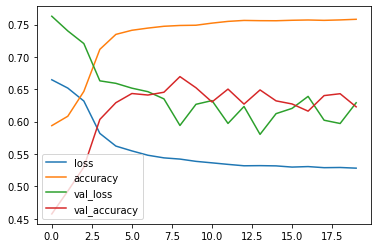

In [335]:
pd.DataFrame(history.history).plot();

In [336]:
y_pred = model.predict(X_test_b)
print(classification_report(y_test, np.round(y_pred)))

1545/1545 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.80      0.88     46151
           1       0.20      0.70      0.31      3260

    accuracy                           0.79     49411
   macro avg       0.59      0.75      0.60     49411
weighted avg       0.92      0.79      0.84     49411



- Good score, let's see if running for more epochs will be better

In [337]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [338]:
history = model.fit(X_train_r, y_train_r, epochs=20, validation_split=0.1,batch_size=256)

Epoch 1/20
660/660 [==============================] - 3s 3ms/step - loss: 0.5280 - accuracy: 0.7577 - val_loss: 0.6193 - val_accuracy: 0.6205
Epoch 2/20
660/660 [==============================] - 2s 2ms/step - loss: 0.5277 - accuracy: 0.7587 - val_loss: 0.6104 - val_accuracy: 0.6334
Epoch 3/20
660/660 [==============================] - 2s 2ms/step - loss: 0.5262 - accuracy: 0.7583 - val_loss: 0.6053 - val_accuracy: 0.6434
Epoch 4/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5275 - accuracy: 0.7577 - val_loss: 0.6074 - val_accuracy: 0.6322
Epoch 5/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5274 - accuracy: 0.7582 - val_loss: 0.6238 - val_accuracy: 0.6167
Epoch 6/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5284 - accuracy: 0.7570 - val_loss: 0.6210 - val_accuracy: 0.6228
Epoch 7/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5269 - accuracy: 0.7575 - val_loss: 0.5922 - val_accuracy: 0.6457
Epoch 

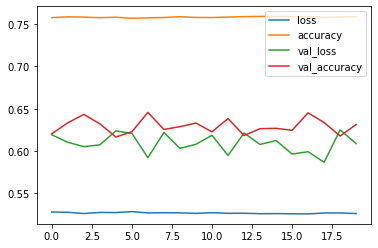

In [339]:
pd.DataFrame(history.history).plot();

In [340]:
y_pred = model.predict(X_test_b)
print(classification_report(y_test, np.round(y_pred)))

1545/1545 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.78      0.86     46151
           1       0.19      0.72      0.29      3260

    accuracy                           0.77     49411
   macro avg       0.58      0.75      0.58     49411
weighted avg       0.92      0.77      0.83     49411



- training loss has stabilized, decent recall score. Let's add more neurons and experiment

### 6.3  16 nodes in the first layer and 16 in the second with oversampling

In [343]:
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler())]
balancer = Pipeline(steps=steps)

In [344]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_r,y_train_r = balancer.fit_resample(X_train,y_train) ## resampling the data
X_train_r = pd.DataFrame(X_train_r, columns=column_names)
X_train_r

X_test_b = imp_scale_transformer.fit_transform(X_test)
X_test_b = pd.DataFrame(X_test_b, columns=column_names)
X_test_b

n_inputs = X_train_r.shape[1]
model = Sequential()
model.add(Dense(16, activation ='relu', input_shape =(n_inputs, )))
model.add(Dropout(0.25))
model.add(Dense(16,activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1,activation ='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_r, y_train_r, epochs=20, validation_split=0.1,batch_size=256)

Epoch 1/20
660/660 [==============================] - 3s 3ms/step - loss: 0.6560 - accuracy: 0.6000 - val_loss: 0.7592 - val_accuracy: 0.4250
Epoch 2/20
660/660 [==============================] - 2s 4ms/step - loss: 0.6093 - accuracy: 0.6778 - val_loss: 0.6545 - val_accuracy: 0.5925
Epoch 3/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5502 - accuracy: 0.7381 - val_loss: 0.6295 - val_accuracy: 0.6330
Epoch 4/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5339 - accuracy: 0.7532 - val_loss: 0.6188 - val_accuracy: 0.6484
Epoch 5/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5271 - accuracy: 0.7570 - val_loss: 0.6466 - val_accuracy: 0.6263
Epoch 6/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5220 - accuracy: 0.7588 - val_loss: 0.5789 - val_accuracy: 0.6738
Epoch 7/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5196 - accuracy: 0.7612 - val_loss: 0.6053 - val_accuracy: 0.6479
Epoch 

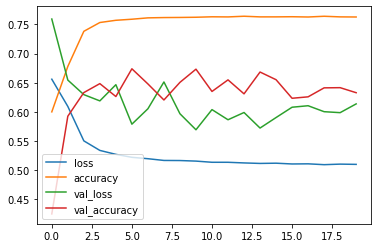

In [345]:
pd.DataFrame(history.history).plot();

In [346]:
y_pred = model.predict(X_test_b)
print(classification_report(y_test, np.round(y_pred)))

1545/1545 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     46151
           1       0.19      0.71      0.30      3260

    accuracy                           0.78     49411
   macro avg       0.58      0.75      0.59     49411
weighted avg       0.92      0.78      0.83     49411



- training loss stabilized in the first 20 epochs itself, no point continuing. Decent recall and accuracy score. Let's add more nodes in the first layer to see the response

### 6.4  32 nodes in the first layer and 16 in the second with oversampling

In [348]:
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_r,y_train_r = balancer.fit_resample(X_train,y_train) ## resampling the data
X_train_r = pd.DataFrame(X_train_r, columns=column_names)
X_train_r

X_test_b = imp_scale_transformer.fit_transform(X_test)
X_test_b = pd.DataFrame(X_test_b, columns=column_names)
X_test_b

n_inputs = X_train_r.shape[1]
model = Sequential()
model.add(Dense(32, activation ='relu', input_shape =(n_inputs, )))
model.add(Dropout(0.25))
model.add(Dense(16,activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1,activation ='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_r, y_train_r, epochs=20, validation_split=0.1,batch_size=256)

Epoch 1/20
660/660 [==============================] - 5s 5ms/step - loss: 0.6521 - accuracy: 0.6051 - val_loss: 0.7555 - val_accuracy: 0.4525
Epoch 2/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5954 - accuracy: 0.6929 - val_loss: 0.6510 - val_accuracy: 0.6022
Epoch 3/20
660/660 [==============================] - 2s 4ms/step - loss: 0.5441 - accuracy: 0.7430 - val_loss: 0.6047 - val_accuracy: 0.6457
Epoch 4/20
660/660 [==============================] - 2s 4ms/step - loss: 0.5293 - accuracy: 0.7533 - val_loss: 0.6198 - val_accuracy: 0.6363
Epoch 5/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5231 - accuracy: 0.7570 - val_loss: 0.5865 - val_accuracy: 0.6590
Epoch 6/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5192 - accuracy: 0.7591 - val_loss: 0.6018 - val_accuracy: 0.6446
Epoch 7/20
660/660 [==============================] - 2s 3ms/step - loss: 0.5179 - accuracy: 0.7596 - val_loss: 0.6098 - val_accuracy: 0.6271
Epoch 

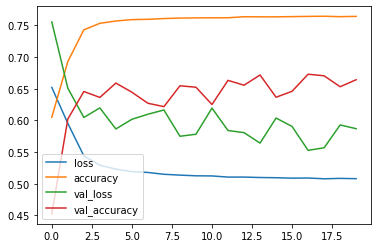

In [349]:
pd.DataFrame(history.history).plot();

-loss has stabilized will not continue

In [350]:
y_pred = model.predict(X_test_b)
print(classification_report(y_test, np.round(y_pred)))

1545/1545 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.79      0.87     46151
           1       0.19      0.71      0.30      3260

    accuracy                           0.78     49411
   macro avg       0.58      0.75      0.59     49411
weighted avg       0.92      0.78      0.83     49411



- adding more nodes hasn't helped. scores are pretty much the same as previous architectures. 

## 7. Conclusion 

- The XGBoost model performs best in comparison to other traditional and Neural Network above.
- it's better interpretability makes it a better model to deploy
- The model should be used as a first pass as it catches 70% of the delinquent accounts, but is prone to over estimating  delinquency.

In [379]:
### End of notebook

- getting the AUC just to compare to models on kaggle

In [375]:
drop_features =['Unnamed: 0','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse']

steps = [('zero_imp',SimpleImputer(strategy= "constant", fill_value=0)),('minmax',MinMaxScaler())]
zero_imp_pipeline_2 = Pipeline(steps=steps)
zero_imp_columns = ['NumberOfDependents','Monthly Income per person']

steps = [('median_imp',SimpleImputer(strategy='median')),('minmax',MinMaxScaler())]
median_imp_pipeline_2 = Pipeline(steps=steps)
median_imp_columns = ['MonthlyIncome']

steps =[('std_scal',StandardScaler())]
std_scal_pipeline = Pipeline(steps =steps)
std_scale_cols = ['age','NumberOfOpenCreditLinesAndLoans'] ## scaling standard as shape is like a bell curve

steps =[('minmaxscal',MinMaxScaler())]
minmax_scale_pipeline = Pipeline(steps=steps)
minmax_scale_cols =['RevolvingUtilizationOfUnsecuredLines',  
                    'DebtRatio', 'NumberRealEstateLoansOrLines', ## scaling minmax as not bell shaped
                    'Total Times Due']

transformers = [('drop_columns', 'drop', drop_features),
                         ('zeroimp',zero_imp_pipeline_2,zero_imp_columns),
                         ('medianimp',median_imp_pipeline_2,median_imp_columns),
                         ( 'stdscale',std_scal_pipeline,std_scale_cols),
                          ('minmaxscale',minmax_scale_pipeline,minmax_scale_cols)]
imp_scale_transformer = ColumnTransformer(transformers=transformers)
column_names =[]
for name, estimator, features in imp_scale_transformer.transformers[1:] :
    column_names += features
    
X_train_copy = X_train.copy() ## clean as required and make a copy of the X_train #################### Remember for final steps
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()


X_train_m= X_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_train_m= y_train.loc[X_train_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
X_test= X_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]
y_test= y_test.loc[X_test_copy['NumberOfTime30-59DaysPastDueNotWorse']<90]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train_m, y_train_m, test_size=0.33, random_state=42,stratify =y_train_m)
steps =[('preprocess',imp_scale_transformer),
        ('ros', RandomOverSampler()),
        ('xgb', XGBClassifier(subsample=0.8,max_depth=2,gamma=0,colsample_bytree=0.8,n_jobs=-1))]
model_xgb3_pipeline = Pipeline(steps=steps)    

In [376]:
model_xgb3_pipeline.fit(X_train_b,y_train_b)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['Unnamed: 0',
                                                   'NumberOfTime30-59DaysPastDueNotWorse',
                                                   'NumberOfTimes90DaysLate',
                                                   'NumberOfTime60-89DaysPastDueNotWorse']),
                                                 ('zeroimp',
                                                  Pipeline(steps=[('zero_imp',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['NumberOfDependents',
                                                   'Monthly...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=2, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

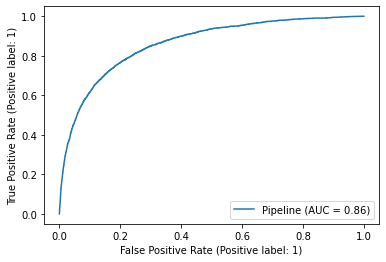

In [385]:
plot_roc_curve(model_xgb3_pipeline,X_test,y_test)

In [386]:
y_pred = model_xgb3_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     46151
           1       0.21      0.77      0.33      3260

    accuracy                           0.80     49411
   macro avg       0.60      0.78      0.61     49411
weighted avg       0.93      0.80      0.84     49411

